[TIME SERIES with using Prophet](#1)

[TIME SERIES VISUALIZATION](#2)

[MAP VISUALIZATION](#3)

[KNN CLASSIFIER WITH IMBALANCED DATA](#4)



In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
plt.style.use("ggplot")
import plotly
import warnings
warnings.filterwarnings("ignore")
!pip install chart_studio
import chart_studio.plotly as py
from plotly.offline import iplot
from plotly.offline import init_notebook_mode, iplot # plotly offline mode
init_notebook_mode(connected=True) 
import plotly.graph_objs as go # plotly graphical object

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<a id="1"></a> <br>
**TIME SERIES with using Prophet**

In [ ]:
data1=pd.read_csv("../input/uncover/apple_mobility_trends/mobility-trends.csv")
# great data to make time series !

In [ ]:
print(data1.info())
print('')
data1.head()

No missing value in data.

In [ ]:
data1['date'] = pd.to_datetime(data1['date'], errors='coerce',format='%Y-%m-%d %H:%M') 
#We need to change date features to datetime for time series analysis.
data1.info()

In [ ]:
data1['year'] = data1['date'].dt.year
data1['month'] = data1['date'].dt.month
data1['week'] = data1['date'].dt.week
data1['day'] = data1['date'].dt.day
data1['day_of_week'] = data1['date'].dt.dayofweek
data1.head()
#day of week 0: monday 
#day of week 6: sunday

In [ ]:
data1=data1.sort_values(by='date') #Sorting data.

In [ ]:
driving=data1.loc[data1["transportation_type"]=='driving']
walking=data1.loc[data1["transportation_type"]=='walking']
transit=data1.loc[data1["transportation_type"]=='transit']

In [ ]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x=driving.groupby('week').value.mean().index, 
                 y=driving.groupby('week').value.mean().values, data=driving)
ax.set_title('Mobility in driving')
ax.set_ylabel('Value');

In [ ]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x=walking.groupby('week').value.mean().index, 
                 y=walking.groupby('week').value.mean().values, data=walking)
ax.set_title('Mobility in walking')
ax.set_ylabel('Value');

In [ ]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x=transit.groupby('week').value.mean().index, 
                 y=transit.groupby('week').value.mean().values, data=transit)
ax.set_title('Mobility in transit')
ax.set_ylabel('Value');

After the 10th week, we can examine the distributions according to the days of the week.

In [ ]:
data1_11=data1.loc[data1["week"]>=11]
data1_11.head()

In [ ]:
walking_11=walking.loc[walking["week"]>=11]
driving_11=driving.loc[driving["week"]>=11]
transit_11=transit.loc[transit["week"]>=11]

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(10,3))
sns.barplot(  y=walking_11.groupby('day_of_week').value.mean().values,
            x= walking_11.groupby('day_of_week').value.mean().index,
            data=walking_11,  orient='v' , ax=axes[0])
axes[0].set(xlabel="Walking day of week", ylabel = "Value")
sns.barplot(  y=driving_11.groupby('day_of_week').value.mean().values,
            x= driving_11.groupby('day_of_week').value.mean().index,
            data=driving_11,  orient='v' , ax=axes[1])
axes[1].set(xlabel="Driving day of week")
sns.barplot(  y=transit_11.groupby('day_of_week').value.mean().values,
            x= transit_11.groupby('day_of_week').value.mean().index,
            data=transit_11,  orient='v' , ax=axes[2])
axes[2].set(xlabel="Transit day of week")
ax.set_title('Mobility in transit')
ax.set_ylabel('Value');

In [ ]:
daily=data1.resample('D', on = 'date').mean() #daily mean
daily=daily[['value']]
plt.figure(figsize=(25,5))
daily.plot(kind = 'line')
plt.show();

In [ ]:
f,ax=plt.subplots(3,1,figsize=(16,9))

df1 = data1.resample('M', on='date').mean()
df1=df1[['value']]
df2 = data1.resample('W', on='date').mean()
df2=df2[['value']]
df3 = data1.resample('D', on='date').mean()
df3=df3[['value']]

df1['value'].plot(ax = ax[0], color = '#DAA520')
ax[0].set_title('Mean Value (monthly)')
ax[0].set_xlabel('')
ax[0].set_ylabel('Mobility Value')

df2['value'].plot(ax = ax[1], color = '#778899')
ax[1].set_title('Mean Delay (weekly)')
ax[1].set_xlabel('')
ax[1].set_ylabel('Mobility Value')

df3['value'].plot(ax = ax[2], color = '#FF69B4')
ax[2].set_title('Mean Delay (daily)')
ax[2].set_xlabel('')
ax[2].set_ylabel('Mobility Value')

f.subplots_adjust(hspace=0.6)
plt.show()

In [ ]:
data1=data1[['date','value']]

In [ ]:
trace=go.Scatter(x=list(data1.date), y=list(data1.value), line=dict(color='#990000'))
data=[trace]
layout=dict(
    title='Mobility Value',
    xaxis=dict(
        rangeselector=dict(
        buttons=list([
            dict(step='all')])
        ),
        rangeslider=dict(visible=True),
        type='date'))
fig=dict(data=data,layout=layout)

import plotly.io as pio
pio.show(fig)

In [ ]:
import fbprophet

data1=data1.rename(columns={'date':'ds' , 'value' : 'y'})
fbp=fbprophet.Prophet()
fbp.fit(data1)

In [ ]:
data1_forecast=fbp.make_future_dataframe(periods=6,freq='W') #adding 6 weeks of data
data1_forecast=fbp.predict(data1_forecast)
fbp.plot(data1_forecast, xlabel='Date', ylabel='Mobility Value')

<a id="2"></a> <br>
**TIME SERIES VISUALIZATION**

In [ ]:
data2=pd.read_csv("../input/uncover/New_York_Times/covid-19-county-level-data.csv")

In [ ]:
data2.head()

In [ ]:
data2['county'].value_counts()[:10]

In [ ]:
washington=data2.loc[data2['county'] == "Washington"]
jefferson=data2.loc[data2['county'] == "Jefferson"]
franklin=data2.loc[data2['county'] == "Franklin"]
jackson=data2.loc[data2['county'] == "Jackson"]

In [ ]:
washington['date'].min(), washington['date'].max()

In [ ]:
washington = washington.sort_values('date')
jefferson = jefferson.sort_values('date')
franklin = franklin.sort_values('date')
jackson = jackson.sort_values('date')

col=['county','state','fips']
washington.drop(col, axis=1, inplace=True)
jefferson.drop(col, axis=1, inplace=True)
franklin.drop(col, axis=1, inplace=True)
jackson.drop(col, axis=1, inplace=True)

washington=washington.groupby('date')['cases','deaths'].sum().reset_index()
jefferson=jefferson.groupby('date')['cases','deaths'].sum().reset_index()
franklin=franklin.groupby('date')['cases','deaths'].sum().reset_index()
jackson=jackson.groupby('date')['cases','deaths'].sum().reset_index()


washington=washington.set_index('date')
jefferson=jefferson.set_index('date')
franklin=franklin.set_index('date')
jackson=jackson.set_index('date')

In [ ]:
washington.head()

In [ ]:
washington.plot(figsize=(10, 4))
plt.show()

In [ ]:
jefferson.plot(figsize=(10, 4))
plt.show()

In [ ]:
franklin.plot(figsize=(10, 4))
plt.show()

In [ ]:
jackson.plot(figsize=(10, 4))
plt.show()

<a id="3"></a> <br>
**MAP VISUALIZATION**

In [ ]:
data3=pd.read_csv("../input/uncover/USAFacts/confirmed-covid-19-deaths-in-us-by-state-and-county.csv")
data4=pd.read_csv("../input/uncover/USAFacts/confirmed-covid-19-cases-in-us-by-state-and-county.csv")

In [ ]:
data3_group=data3.groupby(['county_name','state_name','lat','long'])['deaths'].sum().reset_index()
data4_group=data4.groupby(['county_name','state_name','lat','long'])['confirmed'].sum().reset_index()

#Inner join
data_merge_34=pd.merge(data3_group, data4_group, on=['county_name', 'state_name','lat','long'], how='inner')

In [ ]:
problem=(data_merge_34[data_merge_34['deaths']>data_merge_34['confirmed']])
problem

In [ ]:
data_merge_34.head()

In [ ]:
data_merge_34.info()

In [ ]:
BBox = (data_merge_34.long.min(),   data_merge_34.long.max(),      
         data_merge_34.lat.min(), data_merge_34.lat.max())
print(BBox)

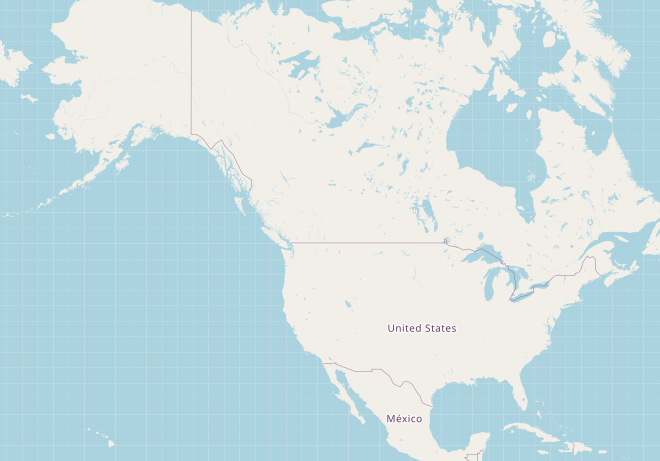

*Exported from here : https://www.openstreetmap.org/#map=3/50.46/-115.84*

In [ ]:
data_merge_34.plot(kind="scatter", x="lat", y="long", alpha=0.1)
plt.show();

In [ ]:
# c is the attribute we'll map onto colors, s is the attribute we'll represent with circle size.
data_merge_34.plot(kind="scatter", x="lat", y="long",
    s=data_merge_34['deaths']/100, label="deaths",
    c="confirmed", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=1, figsize=(10,7),
)
plt.legend()
plt.show()

In [ ]:
#Mean latitude and longitude for each state
mean_lat_long=data_merge_34.groupby(['state_name'])['lat','long'].mean().reset_index()
mean_lat_long.head()

In [ ]:
data34=data_merge_34.groupby(['state_name'])['deaths','confirmed'].sum().reset_index()
data34.head()

In [ ]:
a=data34.merge(mean_lat_long, on='state_name', how='left')
a.head()

In [ ]:
import plotly.graph_objects as go

a['text'] = a['state_name'] + ','+'confirmed: '+a['confirmed'].astype(str)+','+'deaths'+a['deaths'].astype(str)

fig = go.Figure(data=go.Scattergeo(
        lon = a['long'],
        lat = a['lat'],
        text = a['text'],
        mode = 'markers',
        marker_color = a['deaths'],
        ))

fig.update_layout(
        title = 'Death and Confirmed Situations by States',
        geo_scope='usa',
    )
fig.show()

In [ ]:
import folium
center = [37.0902405, -95.7128906]
m = folium.Map(location = center,
               tiles = 'stamenterrain', zoom_start = 4)

#  add Locations to map
for lat, long, deaths, confirmed, state_name in zip(a.lat, a.long, a.deaths, a.confirmed, a.state_name):
    folium.CircleMarker(
        [lat, long],
        radius = 5,
        popup = 'State: {}\nDeaths: {:.0f}\nConfirmed: {:.0f}'.format(state_name, deaths,confirmed),
        fill = True,
        color = 'Red',
        fill_color = 'Green',
        fill_opacity = 0.6
        ).add_to(m)

#Death and confirmed cases information can be achieved for each state.
m

<a id="4"></a> <br>
**KNN Classifier**

In [ ]:
data5=pd.read_csv("../input/uncover/einstein/diagnosis-of-covid-19-and-its-clinical-spectrum.csv")
data5.head()

In [ ]:
data5.describe().T

In [ ]:
data5.shape

In [ ]:
data5.size

In [ ]:
for c in data5.columns:
    print("----%s----"%c)
    print(data5[c].isnull().sum())

In [ ]:
data5.isnull().sum().sum()

In [ ]:
data5 = data5[['patient_id','patient_age_quantile','sars_cov_2_exam_result','patient_addmited_to_regular_ward_1_yes_0_no',
              'patient_addmited_to_semi_intensive_unit_1_yes_0_no','patient_addmited_to_intensive_care_unit_1_yes_0_no']]

In [ ]:
data5.set_index('patient_id', inplace=True)

In [ ]:
data5.rename(columns={"patient_age_quantile":"age_bracket",
                      "sars_cov_2_exam_result":"result",
                      "patient_addmited_to_regular_ward_1_yes_0_no":"regular_ward",
                     "patient_addmited_to_semi_intensive_unit_1_yes_0_no":"semi_intensive",
                     "patient_addmited_to_intensive_care_unit_1_yes_0_no":"intensive_care_unit"},inplace=True)

In [ ]:
data5.head()

In [ ]:
data5['result'] = data5['result'].apply(lambda x: 0 if x == 'negative' else 1)
data5['regular_ward'] = data5['regular_ward'].apply(lambda x: 0 if x == 'f' else 1)
data5['semi_intensive'] = data5['semi_intensive'].apply(lambda x: 0 if x == 'f' else 1)
data5['intensive_care_unit'] = data5['intensive_care_unit'].apply(lambda x: 0 if x == 'f' else 1)

In [ ]:
data5.head()

In [ ]:
data5.corr()

In [ ]:
data5.describe().T

In [ ]:
fig, ax =plt.subplots(1,4, figsize=(20,3))
sns.countplot(data5['age_bracket'], ax=ax[0])
sns.countplot(data5['regular_ward'], ax=ax[1])
sns.countplot(data5['semi_intensive'], ax=ax[2])
sns.countplot(data5['intensive_care_unit'], ax=ax[3])
fig.show()

In [ ]:
sns.countplot(data5['result'])

Our target class is imbalanced. So I will use SMOTE.The library imblearn has a class named imblearn.over_sampling.SMOTE which performs over-sampling using SMOTE

In [ ]:
x = data5.drop(["result"], axis=1)
y = data5["result"]

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)
  
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

model = LogisticRegression()
model.fit(x_train, y_train.ravel())
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

We achieved an accuracy close to 90%. However did you notice a low (1%) recall? Recall of minority class 1 is very low.

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

In [ ]:
print("Before SMOTE x_train shape : {}".format(x_train.shape))
print("Before SMOTE y_train shape: {} \n".format(y_train.shape))

print("Before SMOTE counts of result=1 : {}".format(sum(y_train == 1)))
print("Before SMOTE counts of result=0: {} \n".format(sum(y_train == 0)))

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 1)
x_train_new, y_train_new = smote.fit_sample(x_train, y_train.ravel())

In [ ]:
print("After SMOTE x_train shape : {}".format(x_train_new.shape))
print("After SMOTE y_train shape: {} \n".format(y_train_new.shape))
  
print("After SMOTE counts of result=1 : {}".format(sum(y_train_new == 1)))
print("After SMOTE counts of result=0 : {}".format(sum(y_train_new == 0)))

In [ ]:
model_new = LogisticRegression()
model_new.fit(x_train_new, y_train_new.ravel())
y_pred_new = model_new.predict(x_test)
print(classification_report(y_test, y_pred_new))

In [ ]:
cm_new = confusion_matrix(y_test, y_pred_new)
print(cm_new)

We see that recall value has improved even though the accuracy has decreased.